In [18]:
import os
import sys
sys.path.append('../')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

from authenticate_service_account import main
from utils import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential


In [2]:
# client = main()

# query = """
# SELECT *
# FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
# """

# query_job = client.query(query)

# results = query_job.result()


In [3]:
# data = results.to_dataframe()


In [4]:
# data.to_csv('4Mrows.csv', index=False)


In [5]:
data = pd.read_csv('../raw_data/4Mrows.csv')


In [6]:
data.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
       'ItinLowe

# Start from scratch with data 

## Running preprocessor

In [7]:
processed_data = preprocess(data, ['OriginCty', 'DestinationCty'])
processed_data


,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,Price,PricePerPax,ItineraryRedirects,ODRedirects,redirect_ratio,OD,total_travel_time,total_layover_time,total_distance_traveled,extra_travel_distance
0,NaN,NaN,NaN,BEG,BEG,RS,24,NaN,False,1,...,591.810,591.8100,1,2,0.500000,NaN,575.0,95.0,7265.0,NaN
1,NaN,NaN,NaN,BEG,BEG,RS,24,NaN,False,1,...,637.900,637.9000,1,2,0.500000,NaN,585.0,145.0,7244.0,NaN
2,NaN,NaN,NaN,BEY,BEY,LB,23,NaN,False,0,...,180.110,180.1100,1,4,0.250000,NaN,115.0,0.0,900.0,NaN
3,NaN,NaN,NaN,BEY,BEY,LB,23,NaN,False,0,...,181.190,181.1900,1,4,0.250000,NaN,110.0,0.0,900.0,NaN
4,NaN,NaN,NaN,BEY,BEY,LB,23,NaN,False,0,...,187.100,187.1000,1,4,0.250000,NaN,145.0,0.0,1239.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2580499,ZUH,ZUH,CN,KMG,KMG,CN,5,1133.0,False,0,...,250.530,125.2675,4,5,0.800000,ZUHKMG,120.0,0.0,1133.0,0.0
2580500,ZUH,ZUH,CN,KOW,KOW,CN,21,461.0,False,0,...,52.195,52.1950,1,1,1.000000,ZUHKOW,80.0,0.0,461.0,0.0
2580501,ZYL,ZYL,BD,MAN,MAN,GB,7,8070.0,False,0,...,716.563,716.5630,5,5,1.000000,ZYLMAN,690.0,0.0,8070.0,0.0
2580502,ZYL,ZYL,BD,MAN,MAN,GB,17,8070.0,True,3,...,1774.890,887.4400,1,3,0.333333,ZYLMAN,860.0,495.0,9428.0,1358.0


### Checking the distribution of the redirect ratio


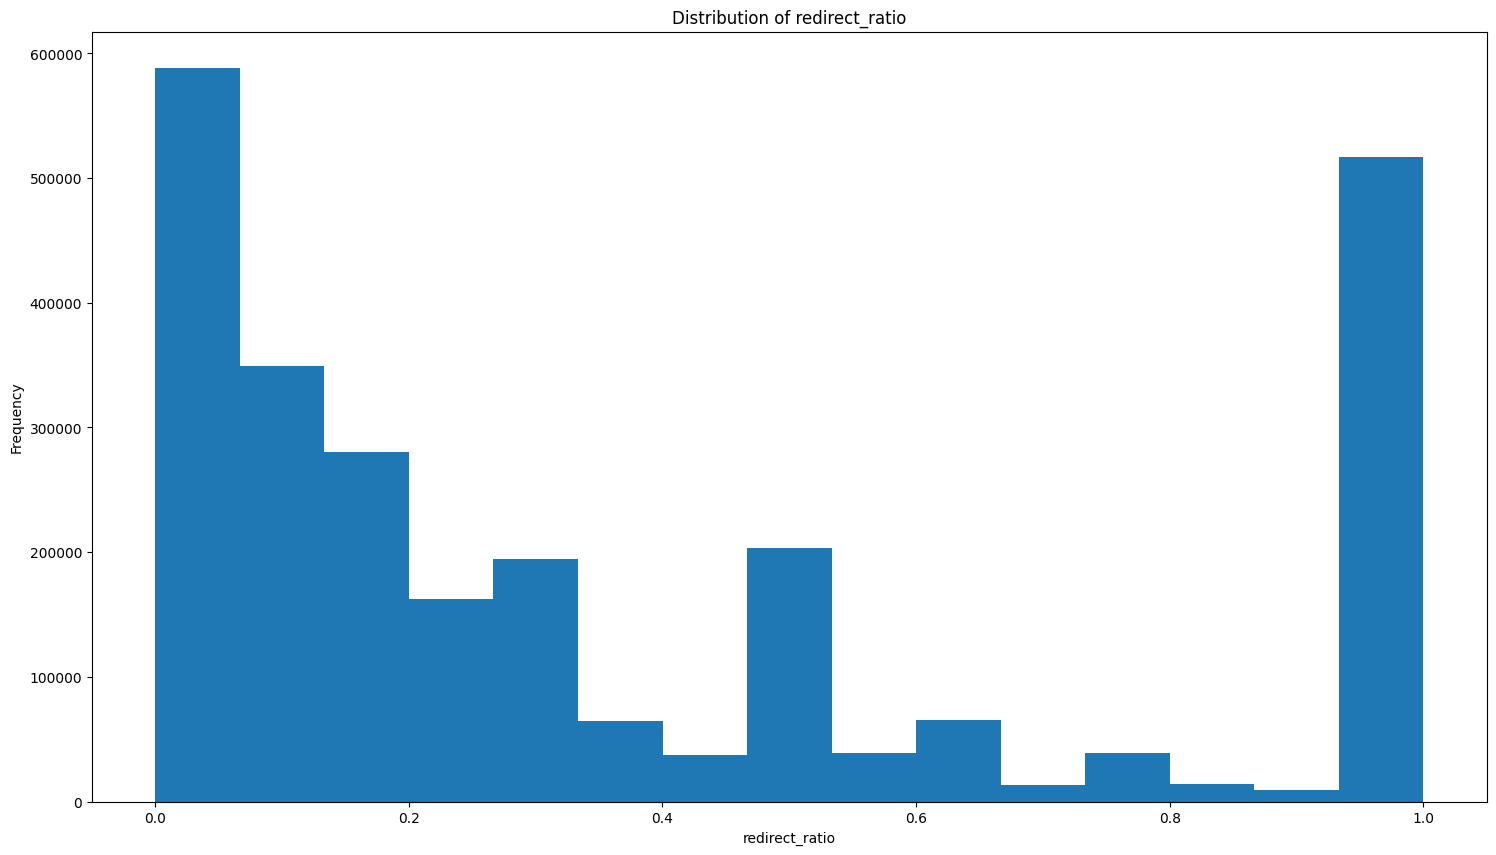

In [8]:
plt.figure(figsize=(18, 10))
plt.hist(processed_data["redirect_ratio"], bins=15)
plt.xlabel("redirect_ratio")
plt.ylabel("Frequency")
plt.title("Distribution of redirect_ratio")
plt.show()


In [9]:
df_grouped = processed_data.groupby(["OriginCty", "OriginApt"]).count()
df_grouped


,,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,DurationMin,Seg_0_OriginIATA,...,Price,PricePerPax,ItineraryRedirects,ODRedirects,redirect_ratio,OD,total_travel_time,total_layover_time,total_distance_traveled,extra_travel_distance
OriginCty,OriginApt,,,,,,,,,,,,,,,,,,,,,
AAE,AAE,150,147,147,147,150,147,150,150,150,150,...,150,150,150,150,150,147,150,150,150,147
AAL,AAL,427,426,426,426,427,426,427,427,427,427,...,427,427,427,427,427,426,427,427,427,426
AAN,AAN,45,44,44,44,45,44,45,45,45,45,...,45,45,45,45,45,44,45,45,45,44
AAR,AAR,338,337,337,337,338,337,338,338,338,338,...,338,338,338,338,338,337,338,338,338,337
AAT,AAT,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZVK,ZVK,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
ZXF,RVK,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
ZYI,WMT,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


## Testing the binary encoder

In [11]:
# import category_encoders as ce
# # Initialize BinaryEncoder
# binary_encoder = ce.BinaryEncoder(cols=["OD"])
# # Fit and transform the data
# binary_encoded_data = binary_encoder.fit_transform(processed_data)
# # Print the result
# print("Binary Encoded data:")
# print(binary_encoded_data.columns)


In [12]:
model_columns = ['ODRedirects', 'TravelDistanceKm', 'Stops', 'TravelHorizonDays',
                     'redirect_ratio', 'SelfTransfer',
                     'total_layover_time', 'extra_travel_distance']

model_data = processed_data[model_columns]


In [13]:
corr_matrix = model_data.corr()
corr_matrix


,ODRedirects,TravelDistanceKm,Stops,TravelHorizonDays,redirect_ratio,SelfTransfer,total_layover_time,extra_travel_distance
ODRedirects,1.000000,-0.061354,-0.088128,-0.095570,-0.289898,-0.044685,-0.040355,-0.035223
TravelDistanceKm,-0.061354,1.000000,0.550701,0.038800,0.054870,0.099576,0.391956,0.412319
Stops,-0.088128,0.550701,1.000000,-0.038042,0.142416,0.445580,0.686405,0.571679
TravelHorizonDays,-0.095570,0.038800,-0.038042,1.000000,0.062637,-0.028231,-0.037003,-0.019636
redirect_ratio,-0.289898,0.054870,0.142416,0.062637,1.000000,0.046109,0.072556,0.075118
SelfTransfer,-0.044685,0.099576,0.445580,-0.028231,0.046109,1.000000,0.377127,0.219194
total_layover_time,-0.040355,0.391956,0.686405,-0.037003,0.072556,0.377127,1.000000,0.471026
extra_travel_distance,-0.035223,0.412319,0.571679,-0.019636,0.075118,0.219194,0.471026,1.000000


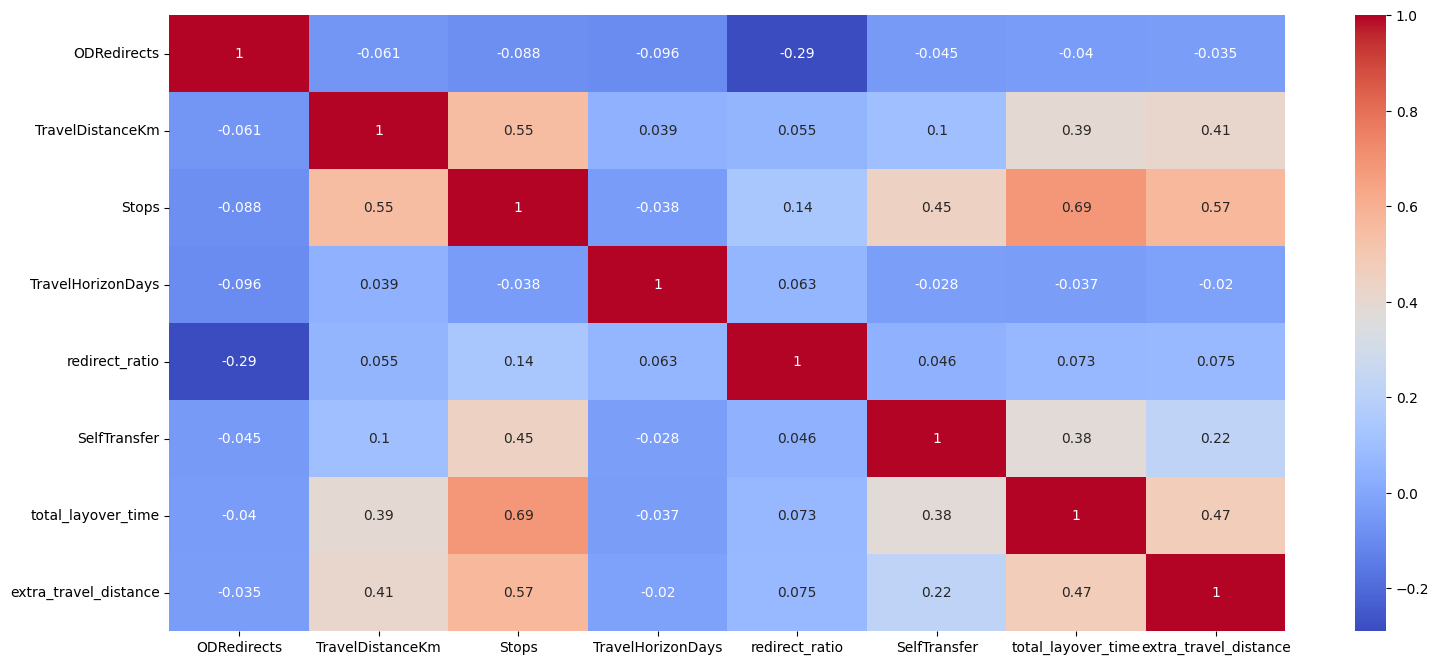

In [14]:
import seaborn as sns
plt.figure(figsize=(18,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [15]:
X_train, X_test, y_train, y_test = create_train_test_split(model_data, 'redirect_ratio')


array([[<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>]], dtype=object)

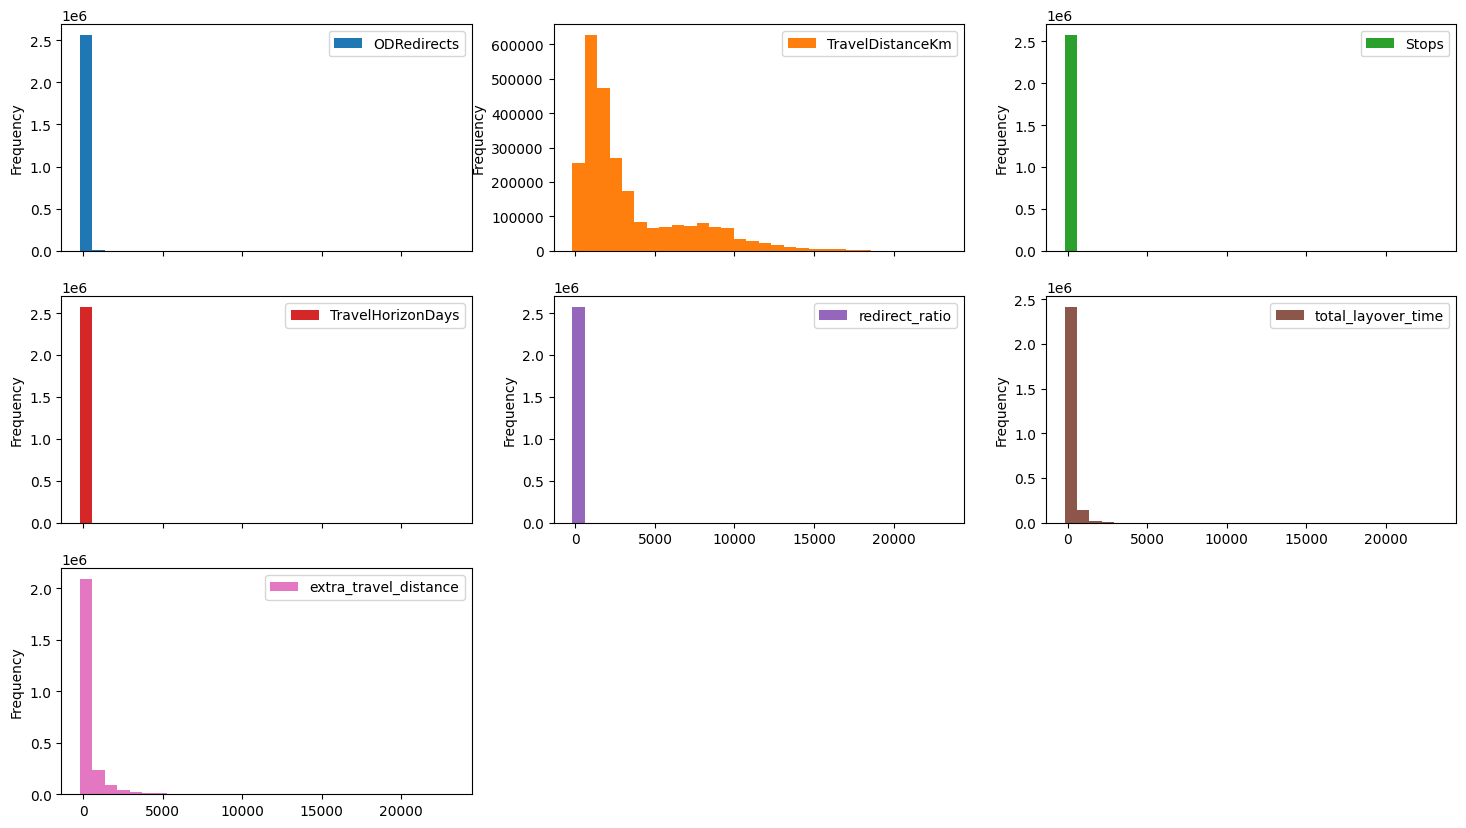

In [26]:
model_data.plot.hist(subplots=True, layout=(3,3), figsize=(18, 10), bins=30)


### TO DO 
- scale with a decent scaler
- change relevant datatypes to something tensorflow will accept 
eg:

X_train = np.array(X_train).astype('float32')
y_train = np.array(y_train).astype('float32')

In [19]:
model = Sequential()
model.add(layers.Dense(64, input_dim=7, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


In [21]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [24]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).